# Mobile Phone Price Classification

This project uses the following dataset with mobile phone parameters: [Mobile Price Classification - Kaggle](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification/data)

The goal is to predict the price class of the phone. The original price class is in 4 categories, but to keep the analysis focused, I will reinterpret the dataset to only include 2 classes: ["Low", "High"].

In [12]:
import pandas as pd
import numpy as np 
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## EDA

The data has the following properties:
- 2000 entries
- 20 feature columns (2 float, 18 int)
- 1 target column (price_range: int) 
- All categories are balanced initially

The original data has 4 categories, I will reinterpret the data to have 2 categories. Here I will take the low-cost category as a single category, and mix the 3 other, higher cost categories to create an artificially unbalanced dataset.

In [2]:
df = pd.read_csv("./train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [3]:
df.describe().T.drop(columns=["count", "25%", "75%"])

,mean,std,min,50%,max
battery_power,1238.51850,439.418206,501.0,1226.0,1998.0
blue,0.49500,0.500100,0.0,0.0,1.0
clock_speed,1.52225,0.816004,0.5,1.5,3.0
dual_sim,0.50950,0.500035,0.0,1.0,1.0
fc,4.30950,4.341444,0.0,3.0,19.0
four_g,0.52150,0.499662,0.0,1.0,1.0
int_memory,32.04650,18.145715,2.0,32.0,64.0
m_dep,0.50175,0.288416,0.1,0.5,1.0
mobile_wt,140.24900,35.399655,80.0,141.0,200.0
n_cores,4.52050,2.287837,1.0,4.0,8.0


There is quite a wide range of values. For example, pixel sizes range in the thousands, while categorical variables (sometimes binary) hover around 0-1. Scaling will be necessary.

In [4]:
df['price_range'].value_counts()

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

The classes are initially balanced, in the preprocessing step the classes will be reinterpreted.

## Preprocessing

Here we will:
- Split the data
- Scale input features (will be done later as part of the GridSearch pipeline)
- Use rebalancing methods to create resampled data.

In [ ]:
target = "price_range"
features = df.columns.drop(target).to_list()

X = df[features]

y = df[target]
y = y.map(lambda v: {0: 0, 1: 1, 2: 1, 3: 1}[v])

y.value_counts()

price_range
1    1500
0     500
Name: count, dtype: int64

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

y_train.value_counts(), y_test.value_counts(), y_smo.value_counts(), y_under.value_counts()

(price_range
 1    1125
 0     375
 Name: count, dtype: int64,
 price_range
 1    375
 0    125
 Name: count, dtype: int64,
 price_range
 1    1125
 0    1125
 Name: count, dtype: int64,
 price_range
 0    375
 1    375
 Name: count, dtype: int64)

## Model Training

### Exploratory LogisticRegression

First, because it is cheap and easy to interpret, we can fit a logisticregression model without hyperparameter tuning, nor rebalancing.

In [17]:
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

def get_accuracy(X_train, X_test, y_train, y_test, model):
    return {
        "test Accuracy":
            metrics.accuracy_score(y_test, model.predict(X_test)),
        "train Accuracy": 
            metrics.accuracy_score(y_train, model.predict(X_train))
        }

In [26]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
evaluate(y_test, y_pred)

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'type': 'Original',
 'accuracy': 0.942,
 'recall': 0.976,
 'auc': 0.908,
 'precision': 0.9481865284974094,
 'fscore': 0.9749001126933716}

We can use this basic model to inspect which features are most important in determining the price. Here we can see that the most important features are:
- Number of cores
- Screen height
- Clock speed
- Primary camera megapixels

In [46]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model):
    coef_dict = {}
    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X_test.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = -coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')

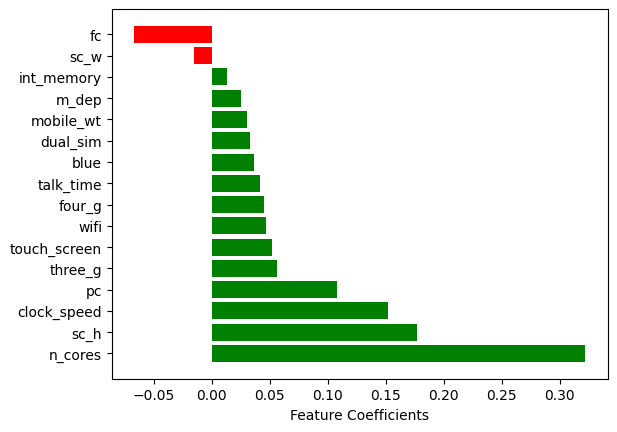

In [47]:
visualize_coefs(get_feature_coefs(lr_model))

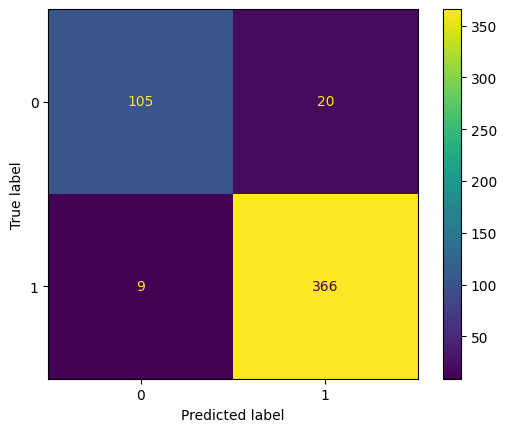

In [9]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

This already performs quite well, but we get a scaling warning. Let's try some other models with GridSearch and see which performs best.

### Gridsearch Training

We'll explore 4 of the models we used in the course:

- LogisticRegression with regularization
- SVC
- RandomForest
- KNN

For each, common parameters are tried with grid search.

In [15]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('model', LogisticRegression())])

params = [
    {
        "scaler": [MinMaxScaler(), StandardScaler(), "passthrough"],
        "model": [LogisticRegression(max_iter=1000)],
        "model__C": [0.1, 1, 10],
        "model__penalty": ["l1", "l2"],
    },
    {
        "scaler": [MinMaxScaler(), StandardScaler(), "passthrough"],
        "model": [KNeighborsClassifier()],
        "model__n_neighbors": [3, 5, 7],
    },
    {
        "scaler": [MinMaxScaler(), StandardScaler(), "passthrough"],
        "model": [RandomForestClassifier()],
        "model__n_estimators": [2*n+1 for n in range(20)],
        "model__criterion": ["gini", "entropy"],
        "model__max_depth": [2*n+1 for n in range(10) ],
        "model__bootstrap": [True, False],
        "model__max_features": ["auto", "sqrt", "log2"],
    },
    {
        "scaler": [MinMaxScaler(), StandardScaler(), "passthrough"],
        "model": [SVC()],
        "model__kernel": ['linear', 'rbf', 'poly', 'sigmoid'],
        "model__C": [0.1, 1, 10, 100],
    }
]

search = GridSearchCV(pipe, params, cv=3)
search.fit(X_train, y_train)

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://sci

,estimator,Pipeline(step...egression())])
,param_grid,"[{'model': [LogisticRegre...max_iter=1000)], 'model__C': [0.1, 1, ...], 'model__penalty': ['l1', 'l2'], 'scaler': [MinMaxScaler(), StandardScaler(), ...]}, {'model': [KNeighborsClassifier()], 'model__n_neighbors': [3, 5, ...], 'scaler': [MinMaxScaler(), StandardScaler(), ...]}, ...]"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,100


In [16]:
search.best_score_, search.best_params_

(np.float64(0.9933333333333333),
 {'model': SVC(),
  'model__C': 100,
  'model__kernel': 'poly',
  'scaler': 'passthrough'})

In [18]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.992, 'train Accuracy': 0.9946666666666667}


Thanks to grid search we now know that the best performing classifier for this dataset is an SVC with a polynomial kernel, no scaling and a C value of 100.

This leads to a 99% accuracy on both test and train sets.

The performance relating to recall, precision and F1 score is also very good.

In [19]:
evaluate(y_test, search.best_estimator_.predict(X_test))

{'type': 'Original',
 'accuracy': 0.992,
 'recall': 0.992,
 'auc': 0.992,
 'precision': 0.9973190348525469,
 'fscore': 0.9922035289290111}

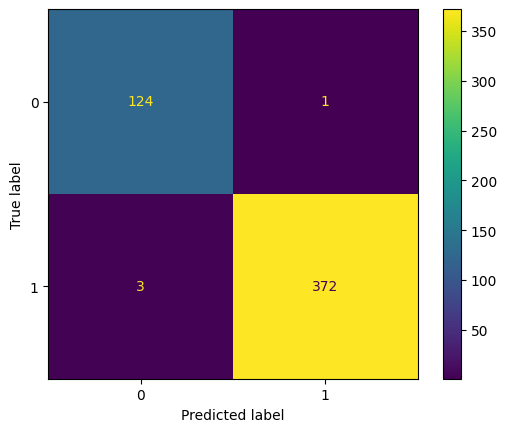

In [79]:
ConfusionMatrixDisplay.from_predictions(y_test, search.best_estimator_.predict(X_test));

The confusion matrix also shows that only 4 samples in total have been misclassified.

## Rebuilding the best model

Now we can reuse the best model and see if rebalancing the classes has some more influence on performance. Previously we created resampled datasets, which we can now use. Together with adding weights to the class loss function.

In [88]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
    plt.yscale('log')
    plt.show()

           type  accuracy  recall    auc  precision    fscore
0      Original     0.992   0.992  0.992   0.997319  0.992204
1      Weighted     0.964   0.952  0.976   1.000000  0.953761
2         SMOTE     0.992   0.992  0.992   0.997319  0.992204
3  Undersampled     0.988   0.984  0.992   1.000000  0.984606


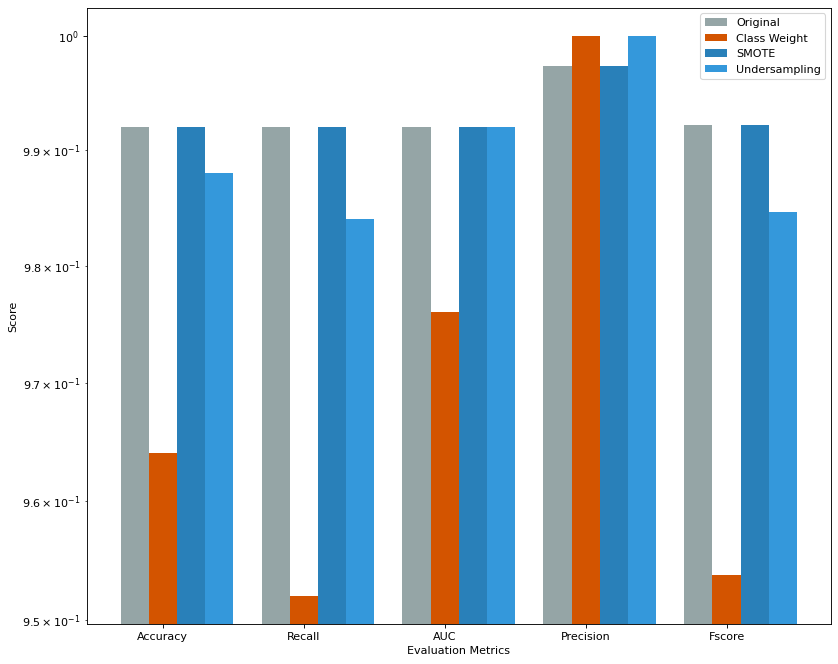

In [89]:
model = SVC(kernel='poly', C=100)

# Original
model.fit(X_train, y_train)
y_pred_original = model.predict(X_test)

# SMO
model.fit(X_smo, y_smo)
y_pred_smo = model.predict(X_test)

# Undersampled
model.fit(X_under, y_under)
y_pred_under = model.predict(X_test)

# Rebalancing
model = SVC(class_weight={0: 0.75, 1: 0.25})
model.fit(X_train, y_train)
y_pred_weight = model.predict(X_test)

results = [
    evaluate(y_test, y_pred_original, "Original"),
    evaluate(y_test, y_pred_weight, "Weighted"),
    evaluate(y_test, y_pred_smo, "SMOTE"),
    evaluate(y_test, y_pred_under, "Undersampled"),
]

visualize_eval_metrics(results)

From this we can see that there is essentially no difference between the non-balanced model and the balanced model.

## Interpretation

For interpretation we can look to the eli5 library. Specifically the `explain_weights` function is very useful in determining which features are important. Unfortunately, the function only works with SVC models with a `linear` kernel/ Luckily the performance is very similar to the polynomial kernel and the interpretability is assumed to transfer.

Here, with scaling the data to ensure that the coefficients are similarly weighted, we can see that the actual most important parameters in the model are:
- Amount of RAM
- Battery power
- Pixel width and height

In [60]:
from eli5 import explain_weights
model = SVC(kernel="linear", C=100)
mms = MinMaxScaler().fit(X_train)
model.fit(mms.transform(X_train), y_train)

evaluate(y_test, model.predict(mms.transform(X_test)))

{'type': 'Original',
 'accuracy': 0.988,
 'recall': 0.9893333333333333,
 'auc': 0.9866666666666666,
 'precision': 0.9946380697050938,
 'fscore': 0.9895363151415675}

In [61]:
explain_weights(model, feature_names=features)

Weight?,Feature
+48.681,ram
+11.978,battery_power
+9.997,px_height
+6.744,px_width
+0.904,fc
+0.708,int_memory
+0.159,four_g
+0.102,m_dep
+0.070,n_cores
+0.057,sc_h


In [77]:
pd.concat(
        [
            pd.Series(model.coef_.flatten()), 
            pd.Series(features)
        ], 
        axis=1
    ).rename(
        {0: "coef", 1: "feature"}, 
        axis=1
    ).set_index(
        "feature"
    ).sort_values(
        by="coef", 
        ascending=False
    )

,coef
feature,
ram,48.680937
battery_power,11.978351
px_height,9.996733
px_width,6.744320
fc,0.904160
int_memory,0.708134
four_g,0.159114
m_dep,0.102296
n_cores,0.070376


## Conclusion

It makes sense that the price is greatly dependent on RAM memory and pixel size. Generally flagship phones have larger screens and more RAM available. Also, similar models with RAM upgrades are generally more expensive. Most other parameters seem to have very minor effects on the outcome, with the largest negative contribution to price (weight), only contributing a factor of -1.7.

It is slightly surprising that features like dual_sim, bluetooth and 3g/4g have little effect on price. The original dataset contains a similar ratio of either, and I would expect these features to have impact on price from a consumer perspective. Another surprise is the low effect of camera number of megapixels, both for the front-facing camera (fc) as for the primary camera (pc). The primary camera even having a negative effect on price, something the simple regression model from earlier also predicted.

### Next steps

At this point the classifier performs well enough that there are no clear next steps. A little more preprocessing might help, since some of the input features (like pixel_height, screen_width, clock_speed, front_camera_megapixels) are skewed. Correcting this might improve model performance slightly. Another option is to use all 4 classes from the source data and see if feature importance changes meaningfully.